# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Импортируем необходимые модули:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time

from sklearn.datasets import fetch_openml
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

Загрузим датасет для дальнейшей работы:

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

Выберем 1000 картинок различной одежды из датасета с 70000 изображениями:

In [4]:
X.shape

(70000, 784)

In [5]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Посмотрим на рандомное изображение из наших данных:

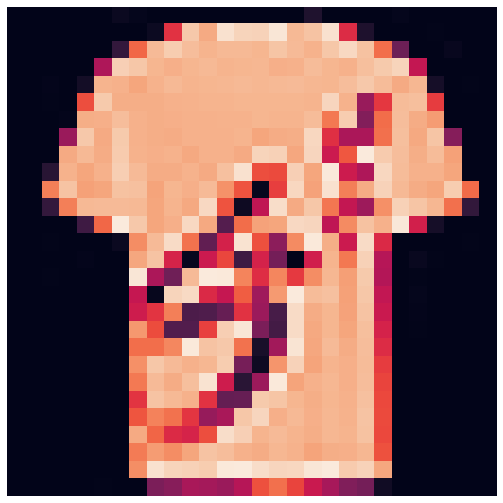

In [12]:
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Изобразим все классы (по 1 картинке из каждого):

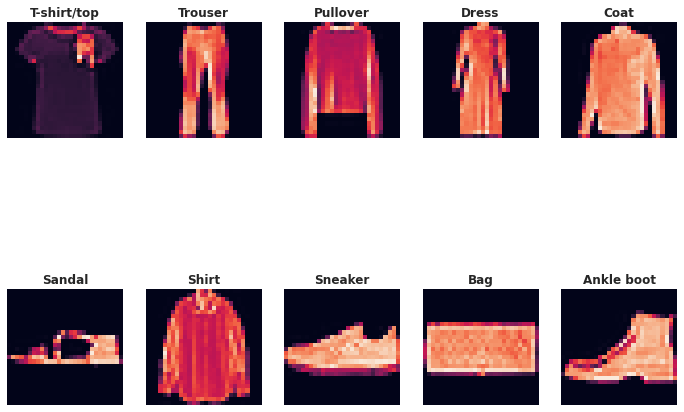

In [13]:
item = np.unique(y, return_counts=False)
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
indexes = list()
for el in item:
    itemindex = np.where(y==el)
    indexes.append(itemindex[0][0])   
for el in range(10):
    plt.subplot(2, 5, el + 1) 
    image = X[indexes[el]].reshape(28, 28, 1)
    plt.imshow(image)
    plt.title(labels[el], fontweight="bold", size=12)
    plt.axis("off")

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрела на баланс классов: частоты встречаемости изображений разных классов различаются не так сильно. В дальнейшем постаралась сохранить этот баланс при разделении на тренировочные и тестовые данные для нашей модели. Как ни пробовала, не получилось зафиксоровать столбцы в направлении от "0" до "9" (или от наибольшей частоты к наименьшей).

In [14]:
unique, counts = np.unique(y, return_counts=True)
for el in range(len(counts)):
    print(f"{labels[el]}: {counts[el]}")

T-shirt/top: 93
Trouser: 102
Pullover: 95
Dress: 121
Coat: 96
Sandal: 98
Shirt: 101
Sneaker: 79
Bag: 109
Ankle boot: 106


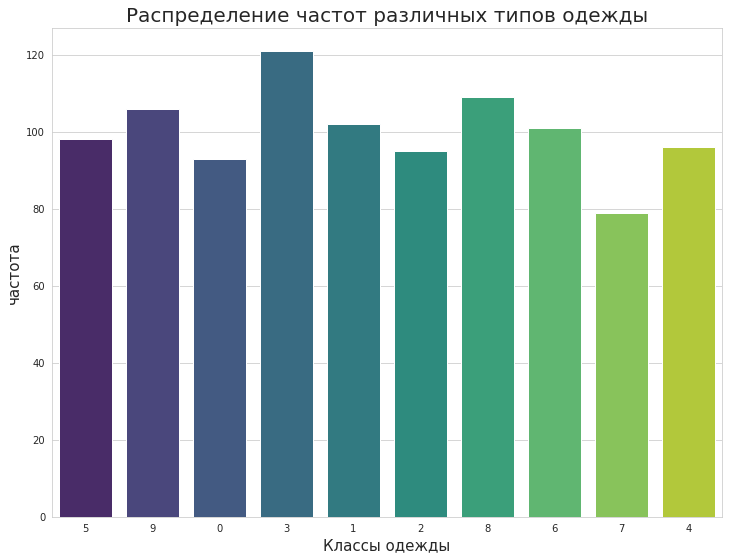

In [15]:
sns.countplot(x = y, palette="viridis")
plt.title("Распределение частот различных типов одежды", fontsize = 20)
plt.xlabel("Классы одежды", fontsize = 15)
plt.ylabel("частота", fontsize = 15)
plt.show()

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделим данные на тренировочную и тестовую выборки (900 и 100 изображений, соответственно):

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)

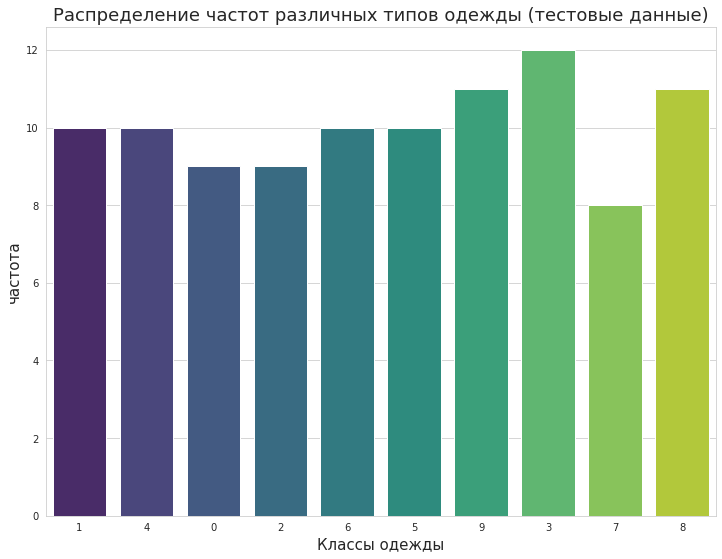

In [17]:
sns.countplot(x = y_test, palette="viridis")
plt.title("Распределение частот различных типов одежды (тестовые данные)", fontsize = 18)
plt.xlabel("Классы одежды", fontsize = 15)
plt.ylabel("частота", fontsize = 15)
plt.show()

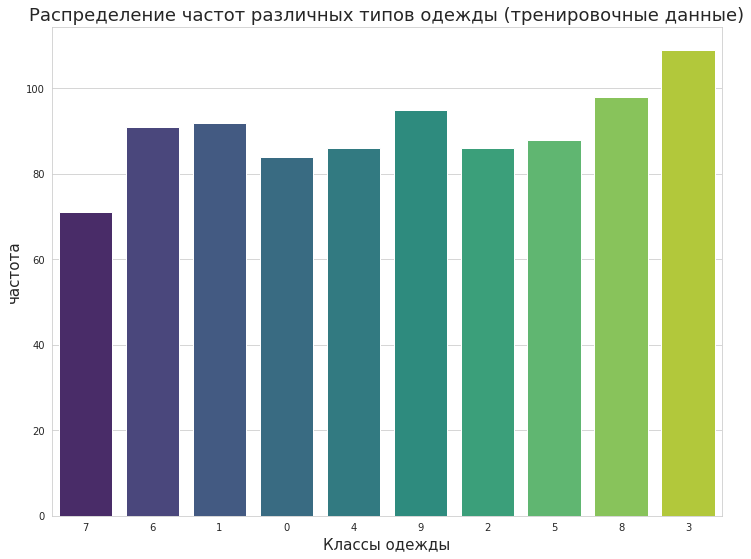

In [18]:
sns.countplot(x = y_train, palette="viridis")
plt.title("Распределение частот различных типов одежды (тренировочные данные)", fontsize = 18)
plt.xlabel("Классы одежды", fontsize = 15)
plt.ylabel("частота", fontsize = 15)
plt.show()

### 1.4. KNN для бинарной классификации (6 баллов)

Для задачи бинарной классификации отберем только объекты с метками классов "0" и "1":

In [19]:
item = ["0", "1"]
indexes = list()
for el in range(len(y_train)):
    if y_train[el] not in item:
        indexes.append(el)
    else:
        continue
binary_train_y = np.delete(y_train, indexes)
binary_train_y[:10]

array(['1', '0', '0', '0', '1', '0', '1', '0', '1', '0'], dtype=object)

In [20]:
binary_train_X = np.delete(X_train, indexes, axis=0)

Проверим, относятся ли оставшиеся изображения в выборке *binary_train_X* к группе "T-shirt/top" и "Trouser":

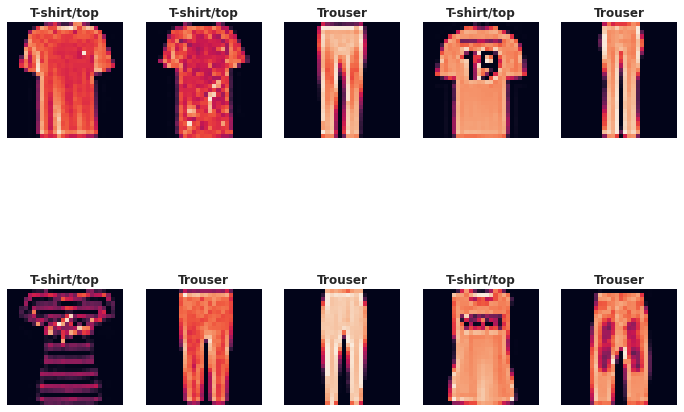

In [21]:
i = 0
for el in random.sample(range(0, len(binary_train_X)), 10):
    plt.subplot(2, 5, i + 1) 
    image = binary_train_X[el].reshape(28, 28, 1)
    if binary_train_y[el] == "0":
        plt.title("T-shirt/top", fontweight="bold", size=12)
    else:
        plt.title("Trouser", fontweight="bold", size=12)
    plt.imshow(image)
    plt.axis("off")
    i += 1

In [22]:
item = ["0", "1"]
indexes = list()
for el in range(len(y_test)):
    if y_test[el] not in item:
        indexes.append(el)
    else:
        continue
binary_test_y = np.delete(y_test, indexes)
binary_test_X = np.delete(X_test, indexes, axis=0)
binary_test_y

array(['1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '1', '1', '1'], dtype=object)

Создадим knn_classifier - образец класса KNNClassifier (параметр к = 1) и передадим ему наши бинарные тренировочные данные (*binary_train_X, binary_train_y*):

In [23]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$
<br><br>

В файле с классами реализуем методы *compute_distances_two_loops, compute_distances_one_loop* и *compute_distances_no_loops*. Выведем на экран массив полученных расстояний (посмотреть, совпадают ли они):

In [24]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
dists

array([[16779., 42055., 50596., ..., 49954., 58616., 23765.],
       [26832., 42260., 50433., ..., 53631., 57689., 33250.],
       [48630., 39778., 35081., ..., 63249., 26831., 47448.],
       ...,
       [20943., 40215., 47616., ..., 52132., 53474., 27157.],
       [21690., 36624., 46841., ..., 48561., 57383., 22954.],
       [26310., 32360., 39461., ..., 48765., 49079., 20502.]])

In [25]:
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
dists

array([[16779., 42055., 50596., ..., 49954., 58616., 23765.],
       [26832., 42260., 50433., ..., 53631., 57689., 33250.],
       [48630., 39778., 35081., ..., 63249., 26831., 47448.],
       ...,
       [20943., 40215., 47616., ..., 52132., 53474., 27157.],
       [21690., 36624., 46841., ..., 48561., 57383., 22954.],
       [26310., 32360., 39461., ..., 48765., 49079., 20502.]])

In [26]:
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
dists

array([[16779., 42055., 50596., ..., 49954., 58616., 23765.],
       [26832., 42260., 50433., ..., 53631., 57689., 33250.],
       [48630., 39778., 35081., ..., 63249., 26831., 47448.],
       ...,
       [20943., 40215., 47616., ..., 52132., 53474., 27157.],
       [21690., 36624., 46841., ..., 48561., 57383., 22954.],
       [26310., 32360., 39461., ..., 48765., 49079., 20502.]])

Проверим скорость работы реализованных методов. Быстрее всех сработал метод без циклов:

In [27]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

392 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
26 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.4 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Реализуем метод для предсказания меток класса:

In [28]:
prediction = knn_classifier.predict(binary_test_X)

Проверим, действительно ли наша модель верно предсказала, относится ли тестовая картинка к группе "T-shirt/top" или "Trouser":

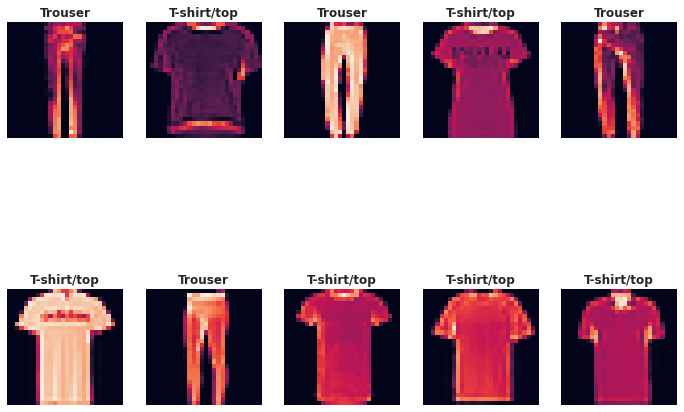

In [29]:
i = 0
for el in random.sample(range(0, len(binary_test_y)), 10):
    plt.subplot(2, 5, i + 1) 
    image = binary_test_X[el].reshape(28, 28, 1)
    if prediction[el] == "0":
        plt.title("T-shirt/top", fontweight="bold", size=12)
    else:
        plt.title("Trouser", fontweight="bold", size=12)
    plt.imshow(image)
    plt.axis("off")
    i += 1

### Метрика

Реализуем метрики для бинарной классификации (*accuracy, precision, recall, F1*):

In [30]:
print("Accuracy =", binary_classification_metrics(prediction, binary_test_y, "accuracy"))
print("Precision =", binary_classification_metrics(prediction, binary_test_y, "precision"))
print("Recall =", binary_classification_metrics(prediction, binary_test_y, "recall"))
print("F1 =", binary_classification_metrics(prediction, binary_test_y, "f1"))

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1 = 1.0


<img src="https://memepedia.ru/wp-content/uploads/2018/10/db1ca89821f8112b986ae36733e7560a.jpeg" width="599" height="454">
<br>
Результат, мягко говоря, удивляет. Посмотрела на полученный *prediction* и *binary_test_y*, они совпадают:

In [31]:
print("Prediction:", *prediction)
print("Binary_test_y:", *binary_test_y)

Prediction: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
Binary_test_y: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1


Проверила реализацию с функциями из библиотеки `sklearn`:

In [32]:
print("Accuracy_score:", accuracy_score(binary_test_y, prediction))
print("Recall_score:", recall_score(binary_test_y, prediction, pos_label = "0"))
print("Precision_score:", precision_score(binary_test_y, prediction, pos_label = "0"))
print("F1_score:", f1_score(binary_test_y, prediction, pos_label = "0"))

Accuracy_score: 1.0
Recall_score: 1.0
Precision_score: 1.0
F1_score: 1.0


### Подбор оптимального k

Функция *choose_best_k* для выбора отптимального числа ближайших соседей:

In [33]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    train_metrics = []
    test_metrics = []  
    print(metric)
    for el in params:
        knn_classifier = KNNClassifier(k=el)
        knn_classifier.fit(X_train, y_train)
        prediction_test = knn_classifier.predict(X_test)
        prediction_train = knn_classifier.predict(X_train)
        print("\nK =", el)
        tr_m = binary_classification_metrics(prediction_train, y_train, metric)
        train_metrics.append(tr_m)
        print("train", tr_m)
        test_m = binary_classification_metrics(prediction_test, y_test, metric)
        test_metrics.append(test_m)
        print("test", tr_m)
    return train_metrics, test_metrics

In [34]:
params = [1, 2, 4, 5, 8, 10, 20, 30, 40, 50, 100]
train_acc, test_acc = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, "accuracy")

accuracy

K = 1
train 1.0
test 1.0

K = 2
train 0.99
test 0.99

K = 4
train 0.99
test 0.99

K = 5
train 0.99
test 0.99

K = 8
train 0.98
test 0.98

K = 10
train 0.96
test 0.96

K = 20
train 0.98
test 0.98

K = 30
train 0.94
test 0.94

K = 40
train 0.92
test 0.92

K = 50
train 0.92
test 0.92

K = 100
train 0.82
test 0.82


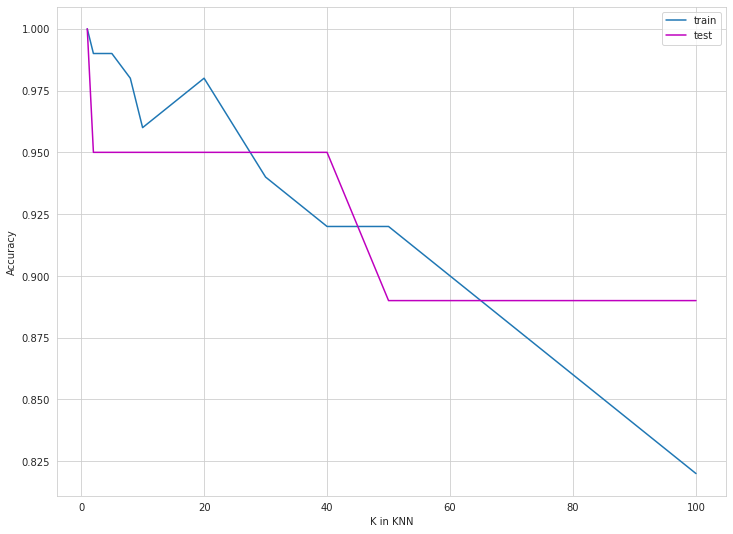

In [54]:
plt.plot(params, train_acc, label="train")
plt.plot(params, test_acc, label="test", color = "m")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy")
plt.show()

In [55]:
train_pre, test_pre = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, "precision")

precision

K = 1
train 1.0
test 1.0

K = 2
train 0.99
test 0.99

K = 4
train 0.99
test 0.99

K = 5
train 0.99
test 0.99

K = 8
train 0.96
test 0.96

K = 10
train 0.94
test 0.94

K = 20
train 0.98
test 0.98

K = 30
train 0.89
test 0.89

K = 40
train 0.86
test 0.86

K = 50
train 0.86
test 0.86

K = 100
train 0.65
test 0.65


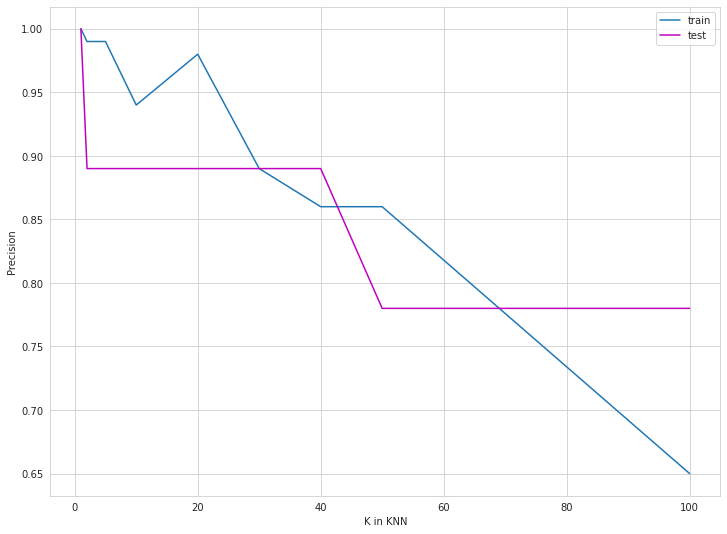

In [56]:
plt.plot(params, train_pre, label="train")
plt.plot(params, test_pre, label="test", color = "m")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Precision")
plt.show()

In [57]:
train_re, test_re = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, "recall")

recall

K = 1
train 1.0
test 1.0

K = 2
train 1.0
test 1.0

K = 4
train 1.0
test 1.0

K = 5
train 0.99
test 0.99

K = 8
train 0.99
test 0.99

K = 10
train 0.98
test 0.98

K = 20
train 0.98
test 0.98

K = 30
train 0.97
test 0.97

K = 40
train 0.97
test 0.97

K = 50
train 0.97
test 0.97

K = 100
train 0.96
test 0.96


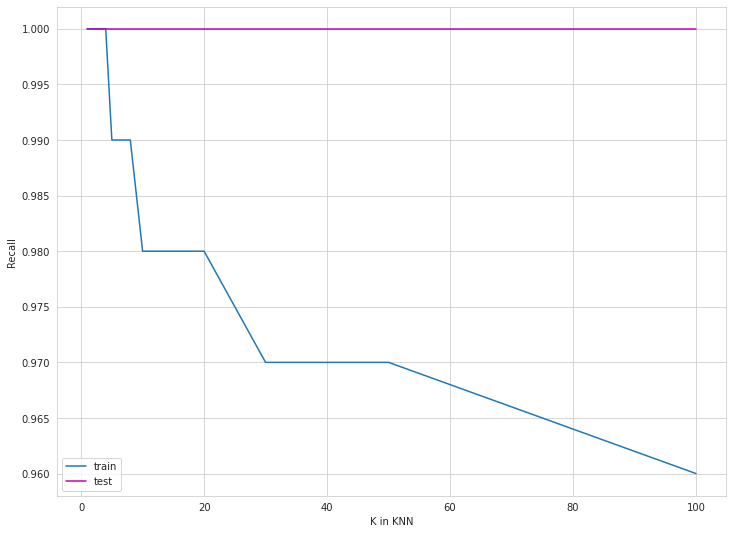

In [58]:
plt.plot(params, train_re, label="train")
plt.plot(params, test_re, label="test", color = "m")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Recall")
plt.show()

In [59]:
train_f1, test_f1 = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, "f1")

f1

K = 1
train 1.0
test 1.0

K = 2
train 0.99
test 0.99

K = 4
train 0.99
test 0.99

K = 5
train 0.99
test 0.99

K = 8
train 0.98
test 0.98

K = 10
train 0.96
test 0.96

K = 20
train 0.98
test 0.98

K = 30
train 0.93
test 0.93

K = 40
train 0.91
test 0.91

K = 50
train 0.91
test 0.91

K = 100
train 0.78
test 0.78


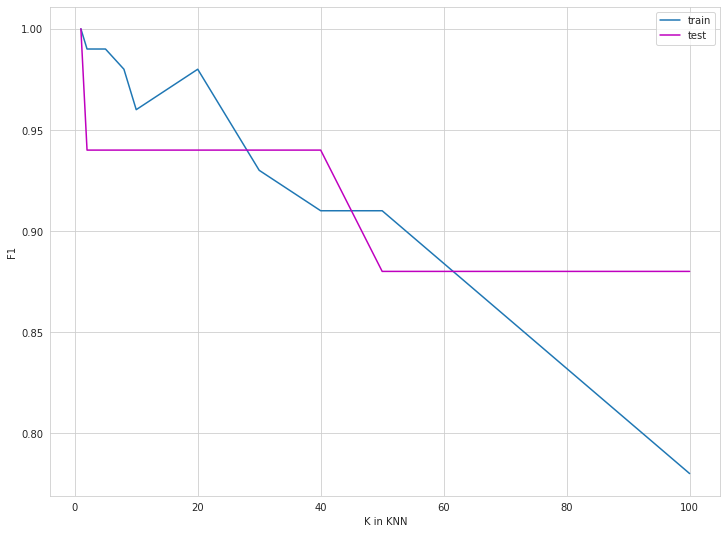

In [60]:
plt.plot(params, train_f1, label="train")
plt.plot(params, test_f1, label="test", color = "m")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("F1")
plt.show()

По совету Данила попробовала встроенный в `sklearn` классификатор c моими тренировочными и тестовыми данными:

In [61]:
train_metrics = []
test_metrics = []  
for k in params:
    neigh = KNeighborsClassifier(n_neighbors=k, p = 1)
    neigh.fit(binary_train_X, binary_train_y)
    y_pred = neigh.predict(binary_test_X)
    y_pred_train = neigh.predict(binary_train_X)
    print("binary_test_y:", *binary_test_y)    
    print("       y_pred:", *y_pred)
    tr_m = round(accuracy_score(binary_train_y, y_pred_train), 3)
    train_metrics.append(tr_m)
    print(f"With k = {k} Train accuracy = {tr_m}")
    te_m = round(accuracy_score(binary_test_y, y_pred), 3)
    test_metrics.append(te_m)
    print(f"With k = {k} Test accuracy = {te_m}")
    print()

binary_test_y: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
       y_pred: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
With k = 1 Train accuracy = 1.0
With k = 1 Test accuracy = 1.0

binary_test_y: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
       y_pred: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
With k = 2 Train accuracy = 1.0
With k = 2 Test accuracy = 1.0

binary_test_y: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
       y_pred: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
With k = 4 Train accuracy = 0.994
With k = 4 Test accuracy = 1.0

binary_test_y: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
       y_pred: 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1
With k = 5 Train accuracy = 0.989
With k = 5 Test accuracy = 0.947

binary_test_y: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
       y_pred: 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1
With k = 8 Train accuracy = 0.983
With k = 8 Test accuracy = 0.947

binary_test_y: 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1
       y_pred: 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1
With k = 10 Train accuracy = 0.983

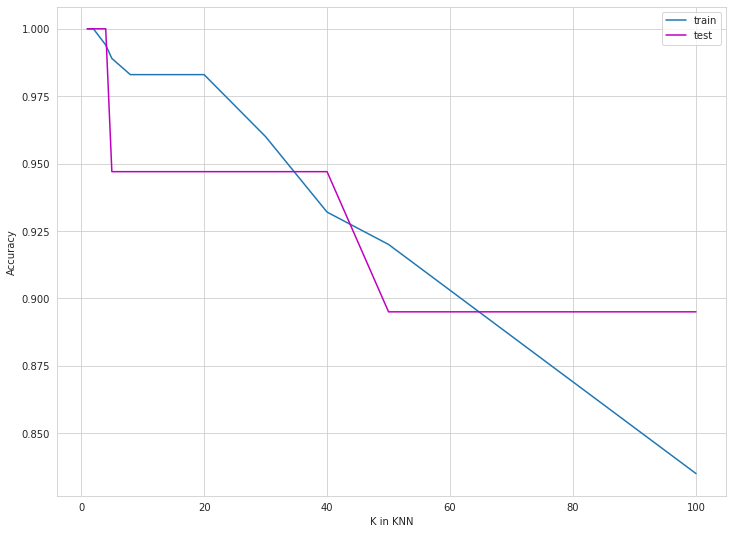

In [62]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test", color = "m")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy")
plt.show()

Получается, оптимальным числом ближайших соседей  будет 1-2.

### 1.5. Многоклассоввая классификация (2 балла)

Реализуем предсказание всех 10 классов:

In [63]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

In [64]:
print(*predictions)
print(*y_test)

1 1 4 0 2 4 7 0 1 5 9 2 4 6 9 3 9 6 9 8 2 8 3 3 7 0 1 4 4 3 3 9 6 2 6 1 6 9 2 4 0 7 9 5 3 8 9 6 3 1 2 0 4 3 2 9 5 6 4 9 0 3 2 9 9 6 3 8 2 5 7 4 5 0 8 9 8 4 7 8 0 0 1 8 5 5 5 5 1 4 1 9 3 8 6 4 1 9 9 8
1 1 4 0 2 6 5 6 1 5 9 2 3 6 7 3 7 6 9 8 2 8 3 3 7 0 1 6 4 3 3 9 6 2 4 1 0 9 3 6 0 7 9 5 3 8 9 4 0 1 6 0 4 3 2 9 5 6 4 9 0 3 2 9 9 4 3 8 2 5 7 4 5 0 8 7 8 2 7 8 0 6 1 8 5 5 5 5 1 4 1 8 3 8 2 4 1 9 7 8


Реализуем метрику качества для многоклассовой классификации (функция *multiclass_accuracy* в `metrics.py`):

In [65]:
multiclass_accuracy(predictions, y_test)

0.79

Выбор оптимального числа ближайших соседей:

In [66]:
# Попытка запустить предсказание на тренировочных данных оборачивается зависшим компьютером :(

def find_best_k_mc(X_train, y_train, X_test, y_test):
    test_metrics = []
    for el in params:
        knn_classifier = KNNClassifier(k=el)
        knn_classifier.fit(X_train, y_train)
        prediction_test = knn_classifier.predict(X_test)
#         prediction_train = knn_classifier.predict(X_train)
        print("\nK =", el)
#         multiclass_accuracy(prediction_train, y_train)
        te_m = multiclass_accuracy(prediction_test, y_test)    
        test_metrics.append(te_m)
        print("Accuracy: ", te_m)
    return test_metrics

In [67]:
test_metrics = find_best_k_mc(X_train, y_train, X_test, y_test)


K = 1
Accuracy:  0.79

K = 2
Accuracy:  0.75

K = 4
Accuracy:  0.78

K = 5
Accuracy:  0.78

K = 8
Accuracy:  0.79

K = 10
Accuracy:  0.77

K = 20
Accuracy:  0.79

K = 30
Accuracy:  0.76

K = 40
Accuracy:  0.76

K = 50
Accuracy:  0.72

K = 100
Accuracy:  0.71


Как и в случае с бинарной классификацией, оптимальное число ближайших соседей примерно 1 (8 и 20).

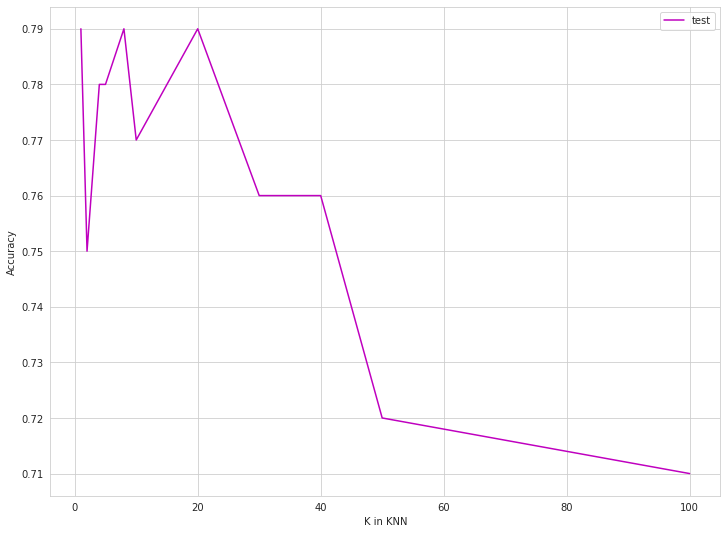

In [68]:
# plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test", color = "m")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

## Задание 2. KNN на датасете diabetes (10 баллов)

Во второй задаче работали с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В таблице представлены стандартизованные результаты измерений биохимических параметров, давления, а также возраст, индекс массы тела (ИМТ) и пол. Таргетная переменная *y* представляет собой количественную оценку прогрессирования заболевания. В данном задании использовала класс `KNeighborsRegressor` из библиотеки `sklearn`.

In [69]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [70]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [71]:
X.head(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349
9,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504


In [72]:
y.head(10)

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
5     97.0
6    138.0
7     63.0
8    110.0
9    310.0
Name: target, dtype: float64

### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

В данной задаче у нас нет необходимости стандартизовать данных - это уже было сделано до нас. Посмотрим на данные с помощью X.shape и X.info. Таблица содержит 442 строки, при этом пустые ячейки отсутствуют:

In [74]:
X.shape

(442, 10)

In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [76]:
X.std()

age    0.047619
sex    0.047619
bmi    0.047619
bp     0.047619
s1     0.047619
s2     0.047619
s3     0.047619
s4     0.047619
s5     0.047619
s6     0.047619
dtype: float64

Визуализируем наблюдения с помощью scatter plot:

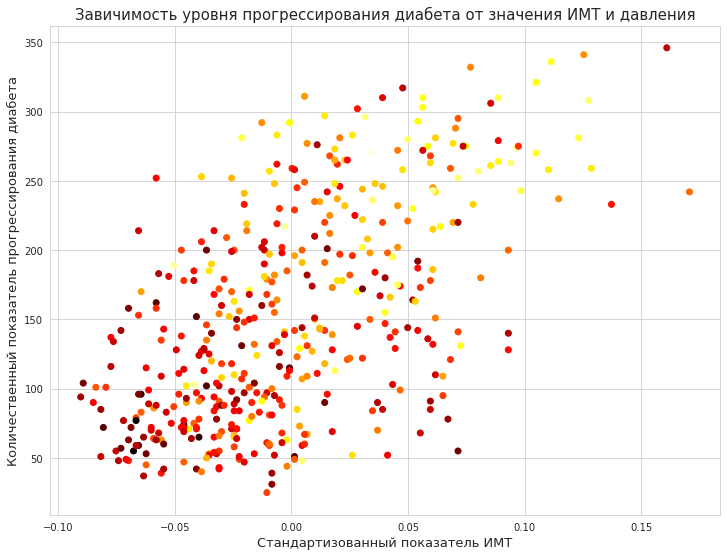

In [77]:
plt.scatter(x = X["bmi"], y = y, c = X["bp"], cmap = "hot", linewidth = 1)
plt.title("Завичимость уровня прогрессирования диабета от значения ИМТ и давления", fontsize = 15)
plt.xlabel("Стандартизованный показатель ИМТ", fontsize = 13)
plt.ylabel("Количественный показатель прогрессирования диабета", fontsize = 13)
plt.show()

### 2.2. Регрессионная модель (1 балл)

Создадим модель `KNeighborsRegressor` и обучите ее на тренировочных данных (k = 1). Воспользуемся встроенным в `sklearn.metrics` *r2_score*, а затем рассчитаем эту метрику сами:

In [78]:
# без пайплайна
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=SEED)

In [79]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
round(r2_score(y_test, y_pred), 3)

-0.307

Для использования пайплайна хорошо бы подошли необработанные данные, которые сначала были бы трансформированы, а затем использовались для обучения модели. Можно написать пайплайн для варианта нашей таблицы, но в данном случае особо нет смысла его использовать (мне так кажется). В случае, если показатель у нас будут категориальные данные (пол), мы сможем использовать LabelEncoder()

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

X.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [81]:
cat_cols = ["sex"]

num_cols = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

all_features = cat_cols + num_cols

target = y

X_pipe = X[all_features]

In [82]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols)
#     ("sex", LabelEncoder(), cat_cols)
])

In [83]:
knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor(n_neighbors=1))
])

Просто попробовала запустить с нашими данными (без категориальных):

In [84]:
knn_pipeline.fit(X_pipe, y)
y_pred = knn_pipeline.predict(X_pipe)
r2_score(y, y_pred)

1.0

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

### 2.4. Подбор оптимального числа соседей (2 балла)

Выберем оптимальное число ближайших соседей:

In [85]:
from metrics import r_squared, mse, mae

Воспользуемся функцией `find_best_k`:

In [86]:
def find_best_k(X_train, y_train, X_test, y_test, new_y_test, params):
    global MSE, MAE, R2
    MSE = []
    R2 = []
    MAE = []
    for el in params:
        knn = KNeighborsRegressor(n_neighbors=el)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        print("\nK =", el)
        r = r_squared(y_pred, y_test_for_metrics)
        R2.append(r)
        print("R2:", round(r, 3))
        ms = mse(y_pred, y_test_for_metrics)
        MSE.append(ms)
        print("MSE:", round(ms, 3))
        ma = mae(y_pred, y_test_for_metrics)
        MAE.append(ma)
        print("MAE:", round(ma, 3))

In [87]:
y_test_for_metrics = y_test.to_numpy()

In [88]:
params = [1, 2, 4, 5, 8, 10, 30, 50, 100]
find_best_k(X_train, y_train, X_test, y_test, y_test_for_metrics, params)


K = 1
R2: -0.307
MSE: 5103.911
MAE: 57.956

K = 2
R2: 0.066
MSE: 3648.672
MAE: 48.122

K = 4
R2: 0.1
MSE: 3515.181
MAE: 44.678

K = 5
R2: 0.141
MSE: 3352.624
MAE: 43.662

K = 8
R2: 0.185
MSE: 3181.217
MAE: 43.967

K = 10
R2: 0.235
MSE: 2988.944
MAE: 41.553

K = 30
R2: 0.285
MSE: 2790.722
MAE: 42.303

K = 50
R2: 0.29
MSE: 2773.891
MAE: 41.319

K = 100
R2: 0.255
MSE: 2910.394
MAE: 43.212


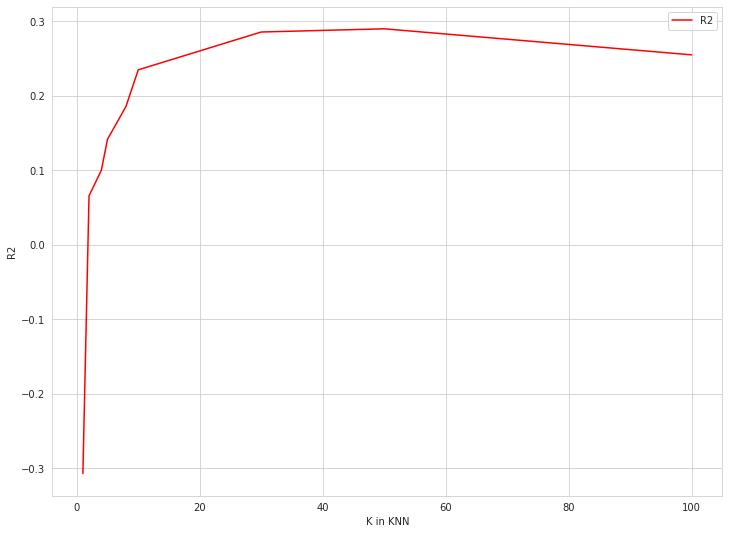

In [91]:
plt.plot(params, R2, label="R2", color = "r")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("R2")
plt.show()

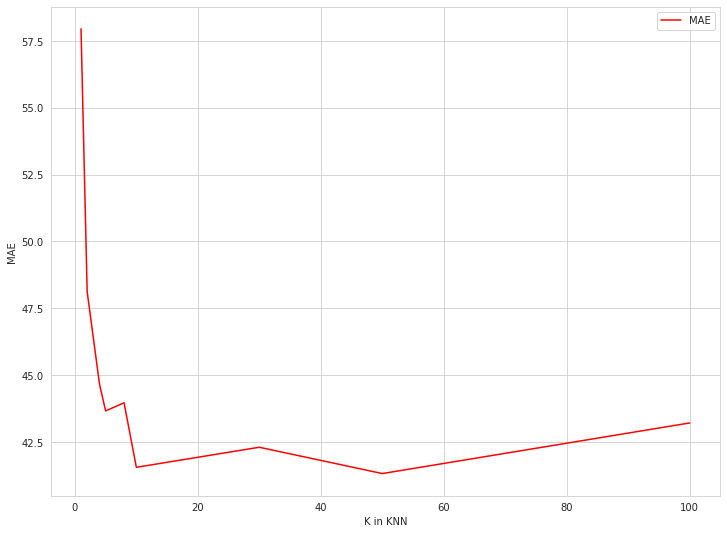

In [92]:
plt.plot(params, MAE, label="MAE", color = "r")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MAE")
plt.show()

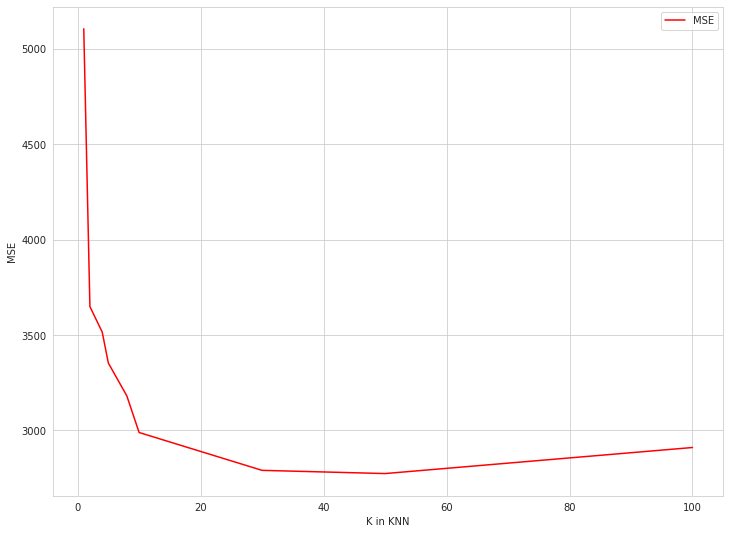

In [93]:
plt.plot(params, MSE, label="MSE", color = "r")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MSE")
plt.show()

При приближении y_pred к y_true показатель R2 должен стремиться к 1, MSE и MAE - к 0. Я бы предположила, что для данной модели оптимальным числом ближайших соседей будет к = 50 ¯\_(ツ)_/¯

## Therapy time

*Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз* 

Вначале была паника: нет навыков работы с numpy, pandas, даже с jupyter не работала ни разу, с матрицами не работали особо. Почти каждое действие и каждый новый шаг был сделан через google. Хорошо, что в интернете много ответов на такие же групые вопросы, которые возникают и у меня. Я в свои первые дни работы над ДЗ:

<img src="https://i.pinimg.com/originals/eb/be/f6/ebbef627c0c826eac368a088522561f3.jpg" width="600" height="600">

потом стало полегче, а в конце даже интересно. Правда, мне теперь очень жаль, что сейчас начнется запара и посвятить неделю подготовке к ДЗ по одному предмету будет реально сложно :(